## Test of deconvolution of the Basic Co-Occurrence Analysis of Human-Cell-Atlas Pancreas Topograhic Maps

Data from Tosti et al, 2021

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.signal
import torch
from sonar import sonar, utils
from numpy.fft import fft, ifft

In [3]:
def create_mat(radius=20,size=500):
    span = np.linspace(-1,1,size)
    X,Y = np.meshgrid(span,span)
    
    cone = 1-(X**2+Y**2)**0.5
    
    return (cone>(1-(radius/size*2)))

In [4]:
# Define the cluster labels of the pancreas tissue matrix:

cluster_labels = ['background',
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan',
 'B cell',
 'T cell',
# 'Endothelial'
]

In [62]:
plt.figure(figsize=[10,10])

n_sample = 1

# Load the pancreas tissue matrix:
tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]

<Figure size 1000x1000 with 0 Axes>

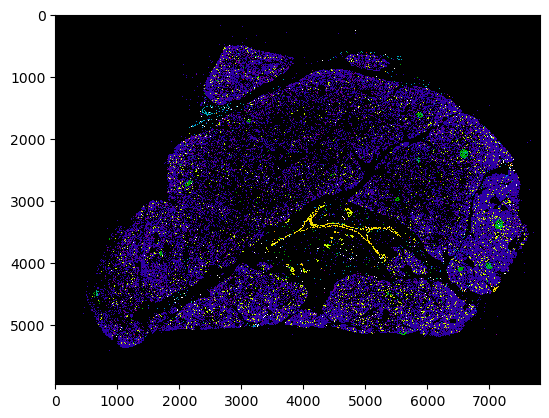

In [6]:
plt.imshow(tissue_matrix.argmax(axis=0),cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(tissue_matrix.sum(0)!=0).astype(float))


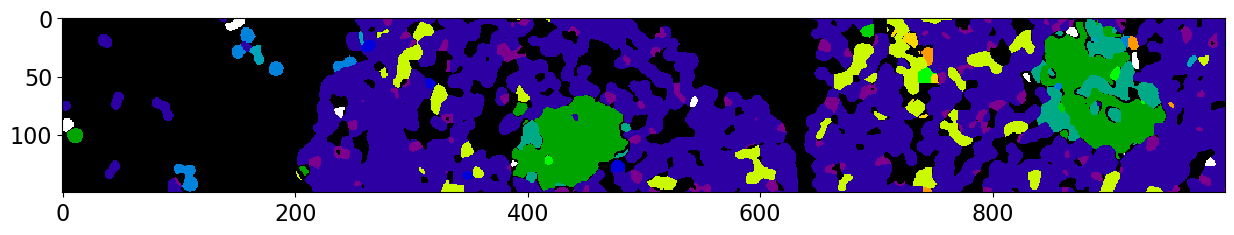

In [72]:
plt.imshow(tissue_matrix.argmax(axis=0)[4000:4150,6100:7100],cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(tissue_matrix.sum(0)[4000:4150,6100:7100]!=0).astype(float))

In [63]:
rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()

In [8]:
original = tissue_matrix.shape
after_scaling = rescaled.shape
scaling_param = original[2]/after_scaling[2]

print(original)
print(after_scaling)
print(scaling_param)

(16, 5960, 7813)
(16, 1788, 2343)
3.3346137430644474


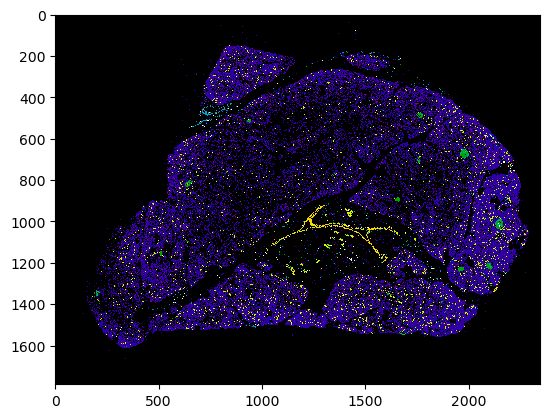

In [9]:
plt.imshow(rescaled.argmax(axis=0),cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(rescaled.sum(0)!=0).astype(float))

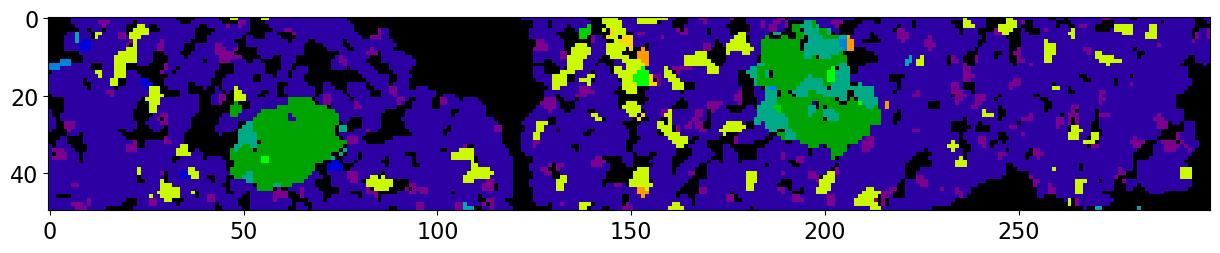

In [81]:
plt.imshow(rescaled.argmax(axis=0)[1200:1250,1900:2200],cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(tissue_matrix.sum(0)[1200:1250,1900:2200]!=0).astype(float))

Changing tasks between cpu and gpu

In [9]:
import torch

if torch.cuda.is_available():
    import torch as t
    device = 'cuda:0' # put it in a gpu
else:
    import torch as t
    device='cpu'


### Stack of cells that compose islets

In [64]:
rescaled_splitted = np.split(rescaled, 16)

In [65]:
islet_stack = np.add.reduce([rescaled_splitted[6],rescaled_splitted[7],rescaled_splitted[8],rescaled_splitted[9]])

In [66]:
def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

son = sonar.Sonar(max_radius=rad_,linear_steps=lin)

cooc_template_ = son.co_occurrence_from_tensor(islet_stack,interpolate=True)

In [67]:
grad = np.diff(cooc_template_)

In [25]:
grad.shape

(1, 1, 499)

(-0.3, 0.05)

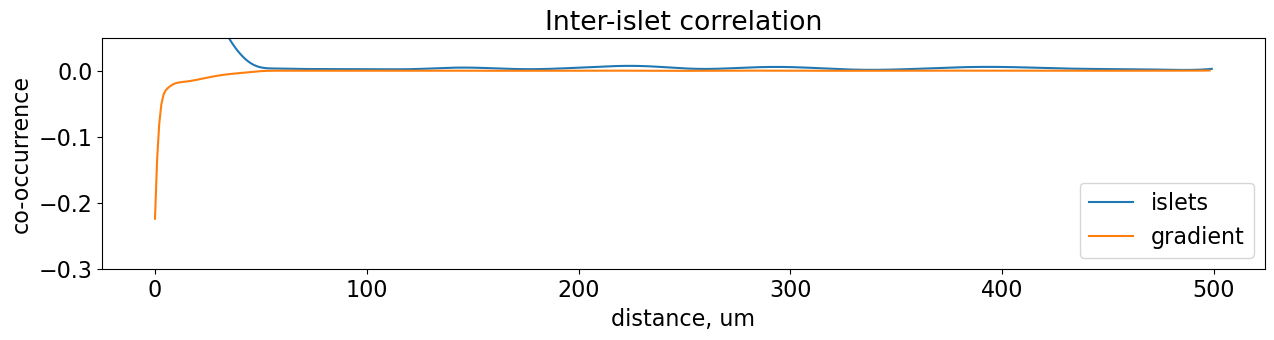

In [70]:
plt.rcParams['figure.figsize'] = [15, 3]
plt.rcParams['font.size'] = '16'

plt.plot(cooc_template_[0,0], label = "islets")
plt.plot(grad[0,0], label = "gradient")

plt.title("Inter-islet correlation")
# plt.ylim((0,0.045))
plt.xlabel('distance, um')
plt.ylabel('co-occurrence')
plt.legend()
plt.ylim(-0.3,0.05)

In [74]:
np.where(grad[0,0] > 0)

(array([ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 177, 178, 179, 180, 181, 182, 183, 184, 185,
        186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
        199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
        212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 260,
        261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
        274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
        287, 288, 289, 290, 291, 292, 339, 340, 341, 342, 343, 344, 345,
        346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358,
        359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371,
        372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384,
        385, 386, 387, 388, 389, 390, 391, 392, 486

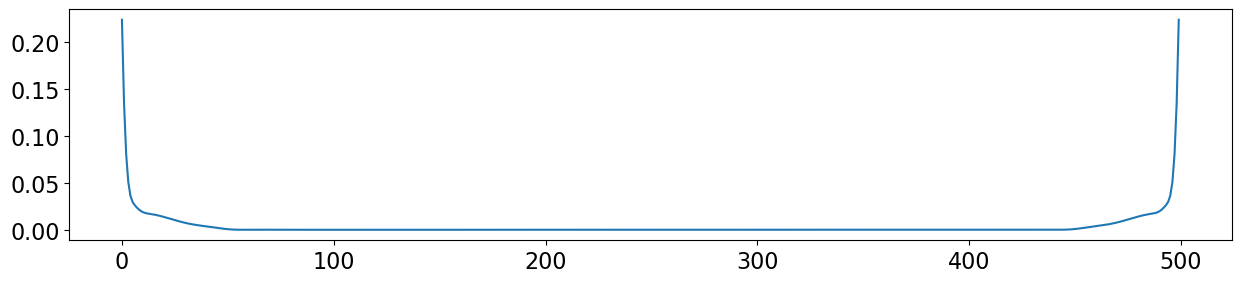

In [81]:
grad_pos = grad[0,0][:97]
extender = np.zeros(500-len(grad_pos)*2)
flipped = -grad_pos
flipped_tail = flipped[::-1]

new_kernel = np.concatenate([flipped, extender, flipped_tail])

plt.plot(new_kernel)

### Test curve

In [10]:
plt.figure(figsize=[5,5])

def create_mat(radius=20,size=500):
    span = np.linspace(-1,1,size)
    X,Y = np.meshgrid(span,span)
    
    cone = 1-(X**2+Y**2)**0.5
    
    return (cone>(1-(radius/size*2)))

<Figure size 500x500 with 0 Axes>

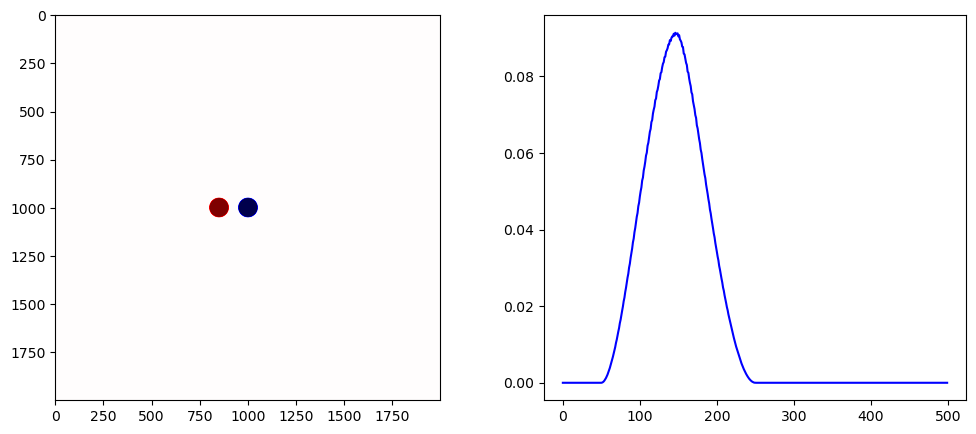

In [13]:
plt.figure(figsize=[12,5])

showcase5_1=[]
showcase5_2=[]
rad_ = 500
rad_cell=50
conveds = []

mat1 = np.roll(create_mat(radius=rad_cell,size=2000),-150,1)
mat2 = np.roll(mat1,150,1)
son = sonar.Sonar(linear_steps=rad_, max_radius=rad_, normalize=True)
#radii, 
co_occurrence_rb = son.co_occurrence_from_tensor(hists=np.array([mat1,mat2]), interpolate=True)

plt.subplot(1,2,1)
plt.imshow(mat1.astype(int)-mat2,cmap='seismic')

plt.subplot(1,2,2)
plt.plot(co_occurrence_rb[1,0], color = 'blue')

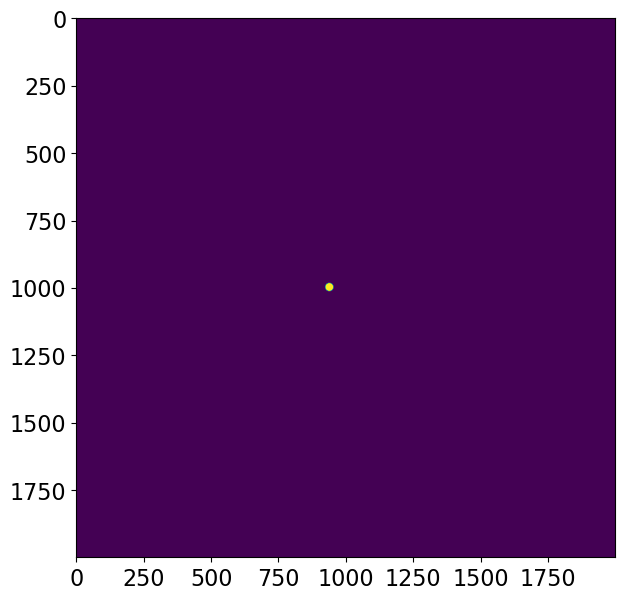

In [32]:
plt.figure(figsize=[7,7])
mat1 = np.roll(create_mat(radius=15,size=2000),-60,1)
plt.imshow(mat1)

### Convolution and deconvolution

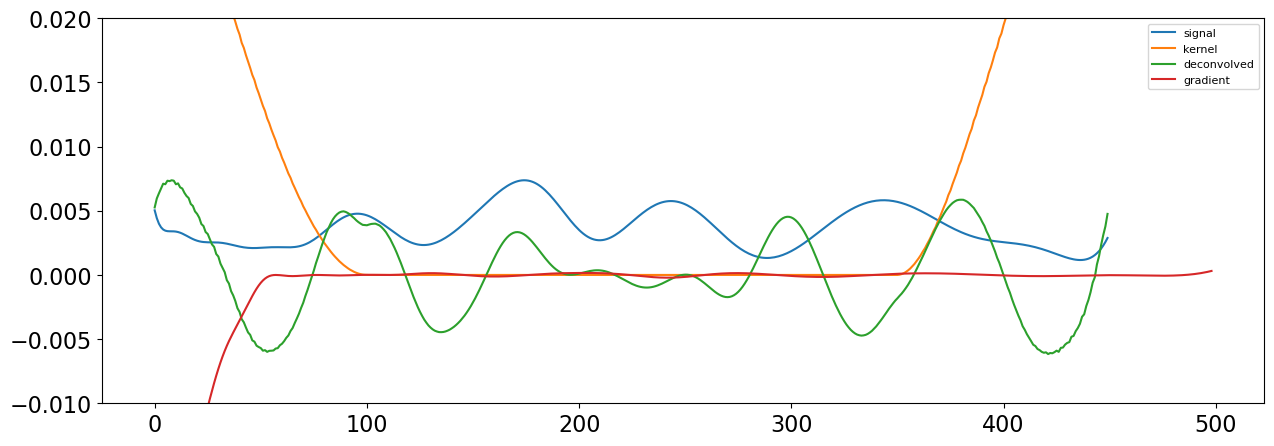

In [42]:
plt.figure(figsize=[15,5])

lambd = 0.01 # <- regularization parameter for Wiener deconvolution  # effect the frequency and max, min values of the deconvolution curve

# extender = np.zeros(20)

signal = cooc_template_[0,0].copy()
signal = signal[50:] #we have less noisy and better over all results if the initial autocorrelation result (of an islet to itsels) is cropped out
kernel = np.roll((co_occurrence_rb[1,0].flatten()[50:]),-100)*0.4 # the size of the curve (*0.5 or any other parameter) effects the result 


kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length

H = fft(kernel)
S = fft(signal)
deconvolved = np.real(ifft(S*np.conj(H)/(H*np.conj(H) + lambd**2))) # <- Wiener deconvolution

plt.plot(signal)
plt.ylim((-0.01,0.02))

plt.plot(kernel)
plt.plot(deconvolved/deconvolved.max()*signal.max())

# plt.plot(grad[0,0], label = "gradient")

plt.legend(['signal','kernel','deconvolved'], fontsize="8")



### Sample 3

In [43]:
n_sample = 3

# Load the pancreas tissue matrix:
tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]

In [ ]:
plt.figure(figsize=[15,8])

plt.subplot(1,2,1)
plt.imshow(tissue_matrix.argmax(axis=0),cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(tissue_matrix.sum(0)!=0).astype(float))

plt.subplot(1,2,2)
plt.imshow(tissue_matrix.argmax(axis=0)[1700:2000,1000:2000],cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(tissue_matrix.sum(0)[1700:2000,1000:2000]!=0).astype(float))

In [45]:
rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()

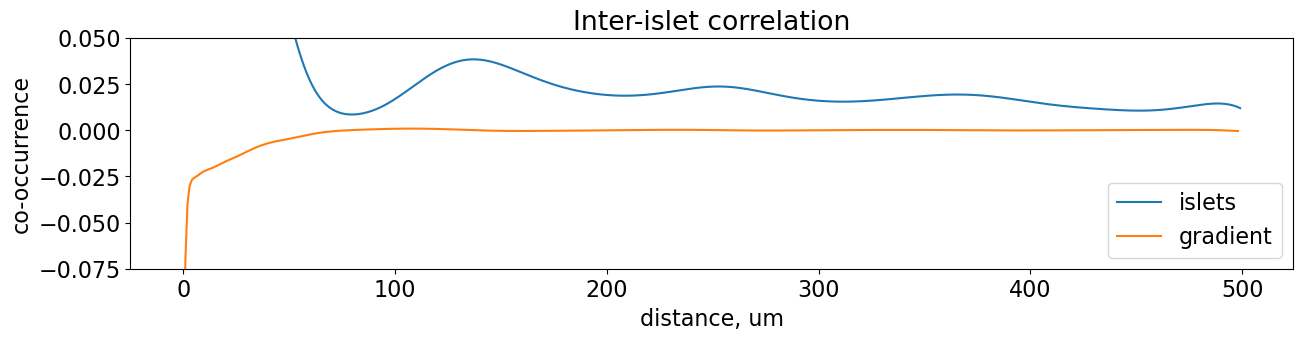

In [51]:
rescaled_splitted = np.split(rescaled, 16)
islet_stack = np.add.reduce([rescaled_splitted[6],rescaled_splitted[7],rescaled_splitted[8],rescaled_splitted[9]])

def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

son = sonar.Sonar(max_radius=rad_,linear_steps=lin)

cooc_template_ = son.co_occurrence_from_tensor(islet_stack,interpolate=True)
grad = np.diff(cooc_template_)


plt.rcParams['figure.figsize'] = [15, 3]
plt.rcParams['font.size'] = '16'

plt.plot(cooc_template_[0,0], label = "islets")
plt.plot(grad[0,0], label="gradient")
plt.title("Inter-islet correlation")
plt.ylim((-0.075,0.05))
plt.xlabel('distance, um')
plt.ylabel('co-occurrence')
plt.legend()

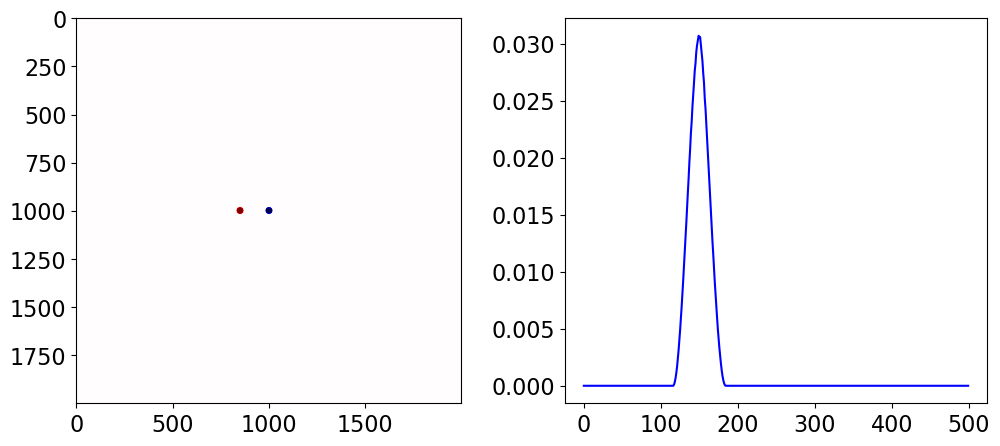

In [43]:
plt.figure(figsize=[12,5])

showcase5_1=[]
showcase5_2=[]
rad_ = 500
rad_cell=17
conveds = []

mat1 = np.roll(create_mat(radius=rad_cell,size=2000),-150,1)
mat2 = np.roll(mat1,150,1)
son = sonar.Sonar(linear_steps=rad_, max_radius=rad_, normalize=True)
#radii, 
co_occurrence_rb = son.co_occurrence_from_tensor(hists=np.array([mat1,mat2]), interpolate=True)


plt.subplot(1,2,1)
plt.imshow(mat1.astype(int)-mat2,cmap='seismic')

plt.subplot(1,2,2)
plt.plot(co_occurrence_rb[1,0], color = 'blue')

In [44]:

co_occurrence_rb[co_occurrence_rb<0] = 0

The kernel is partially negative

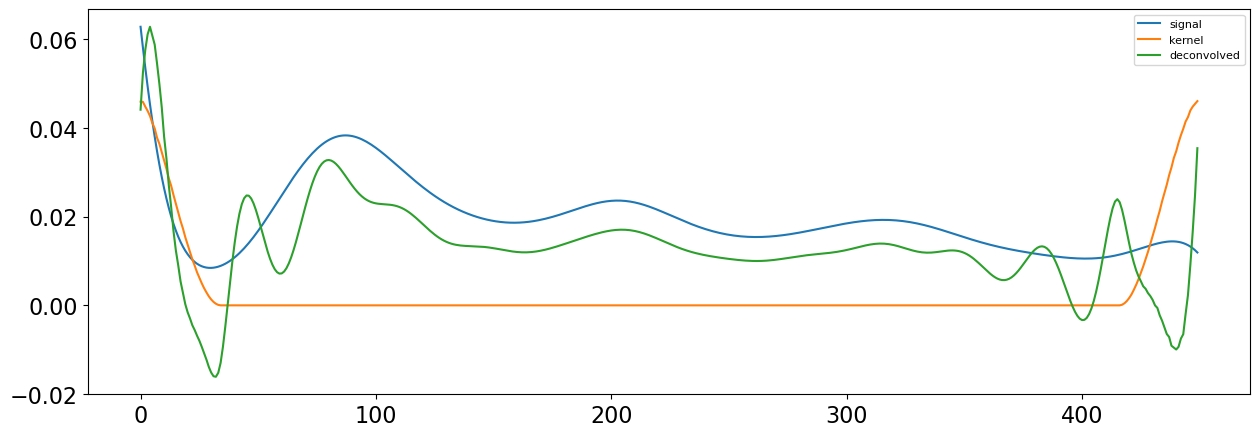

In [54]:
plt.figure(figsize=[15,5])

lambd = 0.1 # <- regularization parameter for Wiener deconvolution  # effect the frequency and max, min values of the deconvolution curve (the lower value, the higher frequency)

# extender = np.zeros(20)

signal = cooc_template_[0,0].copy()
signal = signal[50:] #we have less noisy and better over all results if the initial autocorrelation result (of an islet to itsels) is cropped out
kernel = np.roll((co_occurrence_rb[1,0].flatten()[50:]),-100)*1.5 # the size of the curve (*0.5 or any other parameter) effects the result 

# signal *= np.arange(len(signal))

kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length

H = fft(kernel)
S = fft(signal)
deconvolved = np.real(ifft(S*np.conj(H)/(H*np.conj(H) + lambd**2))) # <- Wiener deconvolution

plt.plot(signal)
# plt.ylim((-0.5,0.5))

plt.plot(kernel)
plt.plot(deconvolved/deconvolved.max()*signal.max())

plt.legend(['signal','kernel','deconvolved'], fontsize="8")

## Sample 2

In [52]:
n_sample = 2

# Load the pancreas tissue matrix:
tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]

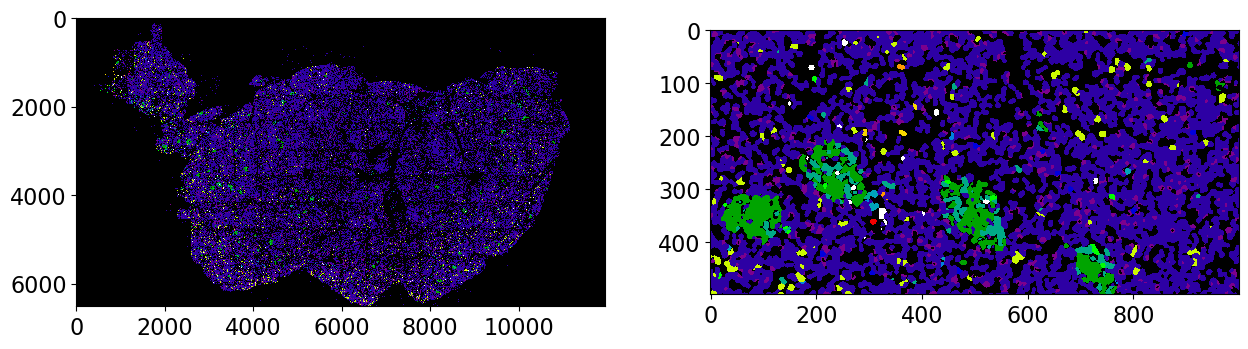

In [56]:
plt.figure(figsize=[15,8])

plt.subplot(1,2,1)
plt.imshow(tissue_matrix.argmax(axis=0),cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(tissue_matrix.sum(0)!=0).astype(float))

plt.subplot(1,2,2)
plt.imshow(tissue_matrix.argmax(axis=0)[3500:4000,3000:4000],cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(tissue_matrix.sum(0)[3500:4000,3000:4000]!=0).astype(float))

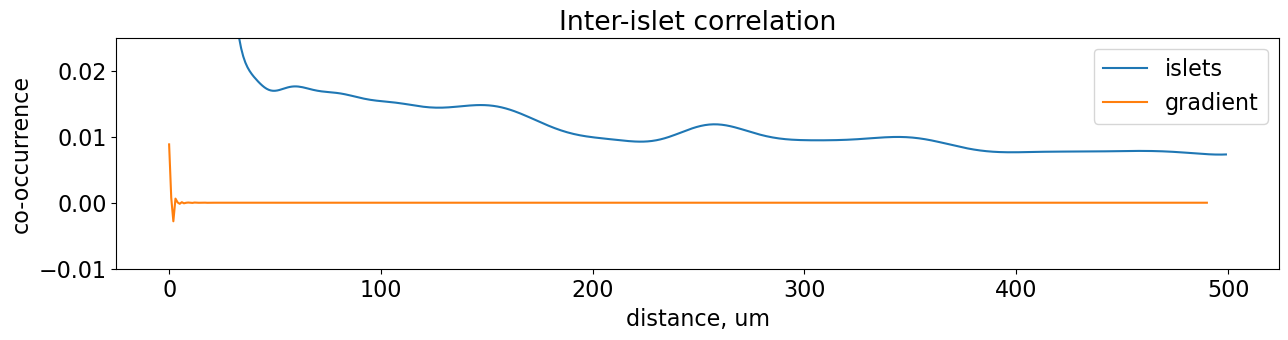

In [60]:
rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()
rescaled_splitted = np.split(rescaled, 16)
islet_stack = np.add.reduce([rescaled_splitted[6],rescaled_splitted[7],rescaled_splitted[8],rescaled_splitted[9]])

def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

son = sonar.Sonar(max_radius=rad_,linear_steps=lin)

cooc_template_ = son.co_occurrence_from_tensor(islet_stack,interpolate=True)
grad = np.diff(grad)

plt.rcParams['figure.figsize'] = [15, 3]
plt.rcParams['font.size'] = '16'

plt.plot(cooc_template_[0,0], label = "islets")
plt.plot(grad[0,0], label = "gradient")

plt.title("Inter-islet correlation")
plt.ylim((-0.01,0.025))
plt.xlabel('distance, um')
plt.ylabel('co-occurrence')
plt.legend()

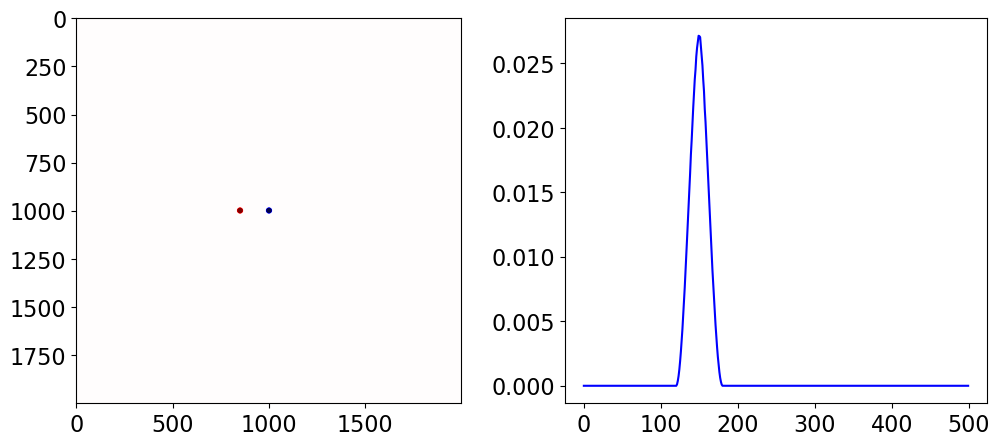

In [58]:
plt.figure(figsize=[12,5])

showcase5_1=[]
showcase5_2=[]
rad_ = 500
rad_cell=15
conveds = []

mat1 = np.roll(create_mat(radius=rad_cell,size=2000),-150,1)
mat2 = np.roll(mat1,150,1)
son = sonar.Sonar(linear_steps=rad_, max_radius=rad_, normalize=True)
#radii, 
co_occurrence_rb = son.co_occurrence_from_tensor(hists=np.array([mat1,mat2]), interpolate=True)


co_occurrence_rb[co_occurrence_rb<0] = 0

plt.subplot(1,2,1)
plt.imshow(mat1.astype(int)-mat2,cmap='seismic')

plt.subplot(1,2,2)
plt.plot(co_occurrence_rb[1,0], color = 'blue')

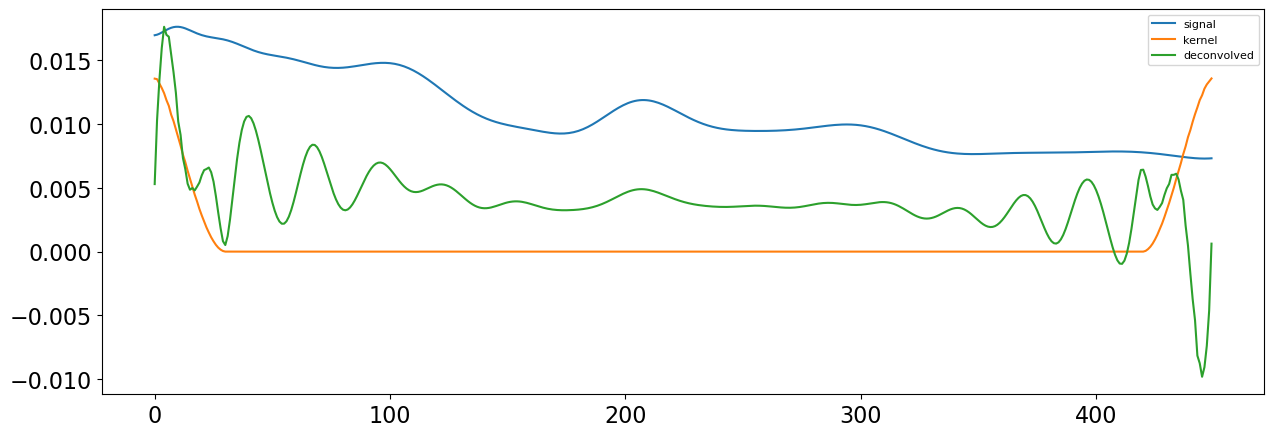

In [64]:
plt.figure(figsize=[15,5])

lambd = 0.01 # <- regularization parameter for Wiener deconvolution  # effect the frequency and max, min values of the deconvolution curve (the lower value, the higher frequency)

# extender = np.zeros(20)

signal = cooc_template_[0,0].copy()
signal = signal[50:] #we have less noisy and better over all results if the initial autocorrelation result (of an islet to itself) is cropped out
kernel = np.roll((co_occurrence_rb[1,0].flatten()[50:]),-100)*0.5 # the size of the curve (*0.5 or any other parameter) effects the result 



# signal *= np.arange(len(signal))

kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length

H = fft(kernel)
S = fft(signal)
deconvolved = np.real(ifft(S*np.conj(H)/(H*np.conj(H) + lambd**2))) # <- Wiener deconvolution

plt.plot(signal)
# plt.ylim((-0.5,0.5))

plt.plot(kernel)
plt.plot(deconvolved/deconvolved.max()*signal.max())

plt.legend(['signal','kernel','deconvolved'], fontsize="8")

## Sample 4

In [65]:
n_sample = 4

# Load the pancreas tissue matrix:
tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]

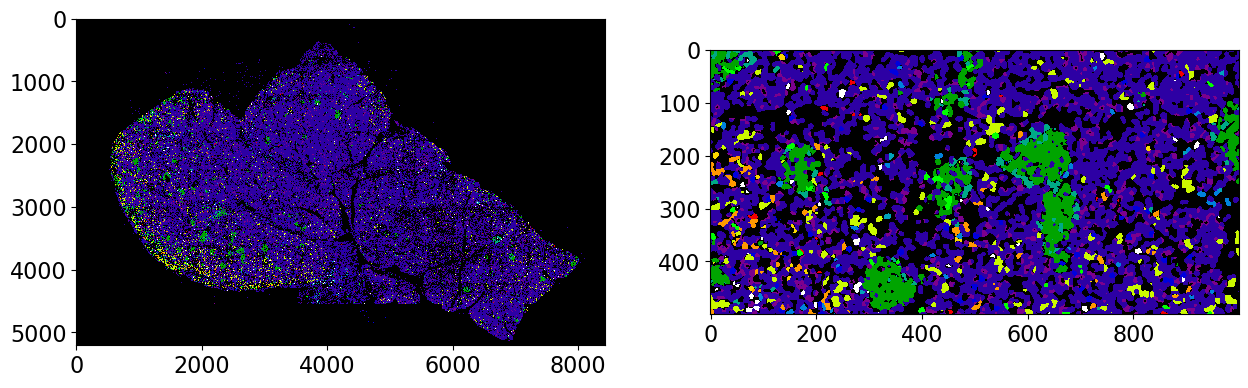

In [66]:
plt.figure(figsize=[15,8])

plt.subplot(1,2,1)
plt.imshow(tissue_matrix.argmax(axis=0),cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(tissue_matrix.sum(0)!=0).astype(float))

plt.subplot(1,2,2)
plt.imshow(tissue_matrix.argmax(axis=0)[3500:4000,2000:3000],cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(tissue_matrix.sum(0)[3500:4000,2000:3000]!=0).astype(float))

In [7]:
%system free -m

['              total        used        free      shared  buff/cache   available',
 'Mem:         385316        3741      225514         198      156059      378525',
 'Swap:          2047         244        1803']

In [8]:
%system top -b -n 1 | grep Cpu


['%Cpu(s):  0.2 us,  0.3 sy,  0.0 ni, 99.5 id,  0.0 wa,  0.0 hi,  0.0 si,  0.0 st']

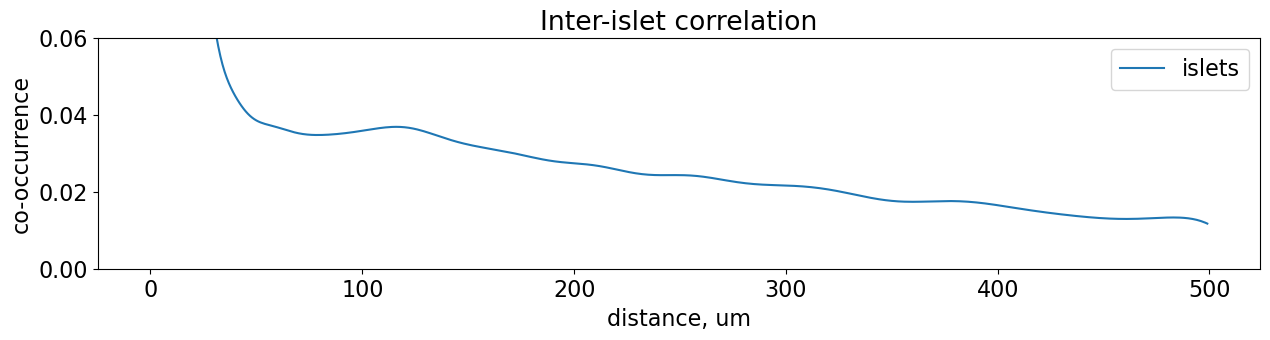

In [67]:
rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()
rescaled_splitted = np.split(rescaled, 16)
islet_stack = np.add.reduce([rescaled_splitted[6],rescaled_splitted[7],rescaled_splitted[8],rescaled_splitted[9]])

def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

son = sonar.Sonar(max_radius=rad_,linear_steps=lin)

cooc_template_ = son.co_occurrence_from_tensor(islet_stack,interpolate=True)

plt.rcParams['figure.figsize'] = [15, 3]
plt.rcParams['font.size'] = '16'

plt.plot(cooc_template_[0,0], label = "islets")
plt.title("Inter-islet correlation")
plt.ylim((0,0.06))
plt.xlabel('distance, um')
plt.ylabel('co-occurrence')
plt.legend()

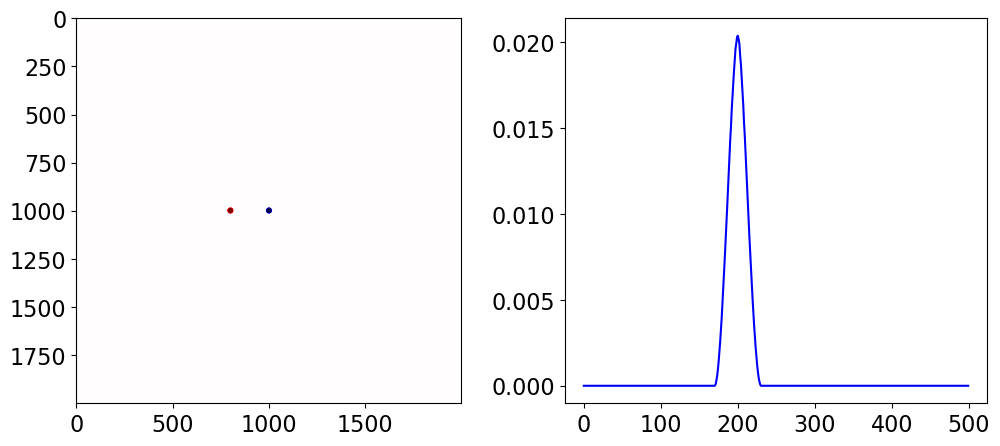

In [68]:
plt.figure(figsize=[12,5])

showcase5_1=[]
showcase5_2=[]
rad_ = 500
rad_cell=15
conveds = []

mat1 = np.roll(create_mat(radius=rad_cell,size=2000),-200,1)
mat2 = np.roll(mat1,200,1)
son = sonar.Sonar(linear_steps=rad_, max_radius=rad_, normalize=True)
#radii, 
co_occurrence_rb = son.co_occurrence_from_tensor(hists=np.array([mat1,mat2]), interpolate=True)


co_occurrence_rb[co_occurrence_rb<0] = 0

plt.subplot(1,2,1)
plt.imshow(mat1.astype(int)-mat2,cmap='seismic')

plt.subplot(1,2,2)
plt.plot(co_occurrence_rb[1,0], color = 'blue')

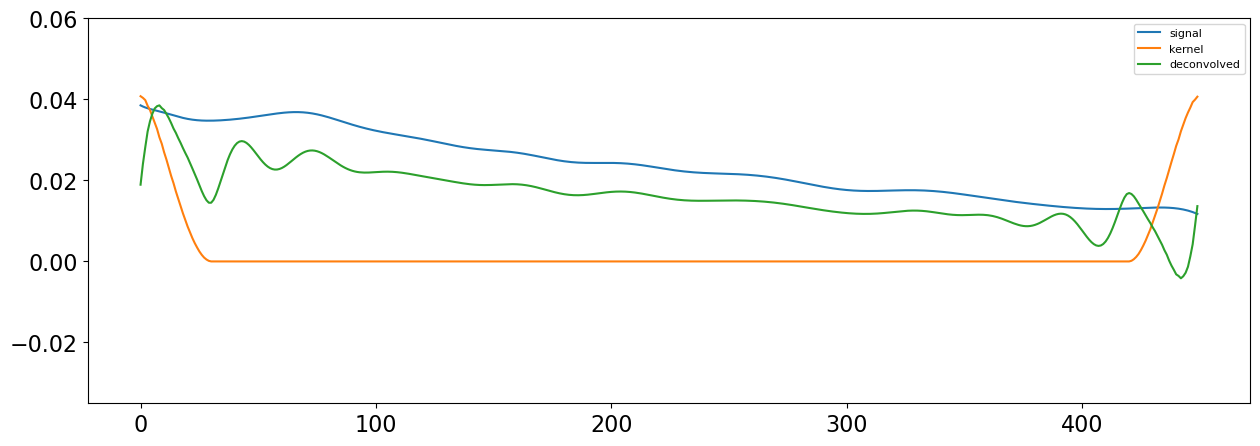

In [79]:
plt.figure(figsize=[15,5])

lambd = 0.1 # <- regularization parameter for Wiener deconvolution  # effect the frequency and max, min values of the deconvolution curve (the lower value, the higher frequency)

# extender = np.zeros(20)

signal = cooc_template_[0,0].copy()
signal = signal[50:] #we have less noisy and better over all results if the initial autocorrelation result (of an islet to itsels) is cropped out
kernel = np.roll((co_occurrence_rb[1,0].flatten()[50:]),-150)*2 # the size of the curve (*0.5 or any other parameter) effects the result 

# signal *= np.arange(len(signal))

kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length

H = fft(kernel)
S = fft(signal)
deconvolved = np.real(ifft(S*np.conj(H)/(H*np.conj(H) + lambd**2))) # <- Wiener deconvolution

plt.plot(signal)
plt.ylim((-0.035,0.06))

plt.plot(kernel)
plt.plot(deconvolved/deconvolved.max()*signal.max())

plt.legend(['signal','kernel','deconvolved'], fontsize="8")